# LAX, What do you want to know?


This project is originally from my curiosity. While travelling to LAX, these questions came to my mind.

- Where do the flights landed in LAX depart from? How many flights?
- Predict delay?
- What is the busiest time?

I was trying to search them up, but, unfortunately, Google didn't satisfy my curioisty. (You can try!). Well, let answer them by myself then!!


### What to expect?

- Fun! Fulfil your curiosity

### What not to expect?

- Cutting-edge technology or novel approach, nah, not at all. Just simple tools that everyone knows.
- Price Analysis. Go to Expedia if you want!




In [1]:
from scrape import daily, sort_flight_by_time
import json
import pandas as pd
import requests

## Where to get data?

First of all, there are many websites that provide realtime fligts information in LAX. I decided to use [this]( https://www.airport-la.com/lax/arrivals). As you can see, its structure is very simple, mostly HTML. Easy to scrape, huh?


* Run the script manually
* Host it somewhere
    * https://www.pythonanywhere.com/ (free)
    * AWS Free Tier

In [2]:
daily()

with open("database.json", "r") as f:
    db = json.load(f)


Then what next? The table from [Airport-LA website](https://www.airport-la.com/lax/arrivals) has IATA code, which is .... Maybe we need something that make more sense for normal people, like where exacyly they are? Also [Airport-LA website](https://www.airport-la.com/lax/arrivals)  tells you the city where flights are from but not country. Do you know where on earth is Puerto Vallarta?? I don't know and I don't want wasting time search it up everytime. Let's make some tools to visualize!!


1. IATA Airport Code from  https://datahub.io/core/airport-codes
2. Country Code from https://datahub.io/core/country-list


In [3]:
airport_locations_response = requests.get("https://datahub.io/core/airport-codes/r/airport-codes.json")
if airport_locations_response.status_code == 200:
    airport_locations = {e["iata_code"]: {
        "display_name": e["name"],
        "lat": e["coordinates"].split(",")[0],
        "lon": e["coordinates"].split(",")[1],
        "country": e["iso_country"]
    } for e in airport_locations_response.json() if e["iata_code"] is not None}
else:
    print("unable to download IATA Data")

country_code_response = requests.get("https://datahub.io/core/country-list/r/data.json")
if country_code_response.status_code == 200:
    country_code = {e["Code"]: e["Name"] for e in country_code_response.json()}
else:
    print("unable to download Country Data")


In [4]:
df = sort_flight_by_time(db, airport_locations, country_code)

error in date format Monday, 24 February from 23:00 to 01:00  
error in date format Monday, 24 February from 22:00 to 00:00  


Let's see what is our data looks like!

In [5]:
df.head()

,dt_scheduled,dt_actual,flight,gate,airport,city,country,lat,long,display name,status
0,2020-02-19 07:10:00,2020-02-20 06:53:00,TN2,TBIT,PPT,Papeete,French Polynesia,-149.606995,-17.553699,Faa'a International Airport,Landed
1,2020-02-19 07:14:00,2020-02-19 07:13:00,DL1240,2 25,SAN,San Diego,United States,-117.190002441,32.7336006165,San Diego International Airport,Landed
2,2020-02-19 07:15:00,2020-02-20 06:49:00,WN1270,1 11A,RNO,Reno,United States,-119.76799774169922,39.49909973144531,Reno Tahoe International Airport,Landed
3,2020-02-19 07:18:00,2020-02-19 07:12:00,AA1356,4 40,LAS,Las Vegas,United States,-115.1520004,36.08010101,McCarran International Airport,Landed
4,2020-02-19 07:18:00,2020-02-20 06:50:00,OO5626,7 75A,SBP,San Luis Obispo,United States,-120.641998291,35.236801147499996,San Luis County Regional Airport,Landed


### What is the busiest time?

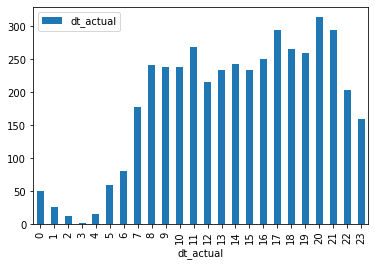

In [6]:
df[["dt_actual"]].groupby(df["dt_actual"].dt.hour).count().plot(kind="bar")

### What City?

In [7]:
df[["flight", "city", "country"]].groupby(["country", "city"]).count().sort_values(["flight"], ascending=False).head(20)

flight
country       city                  
United States San Francisco      258
              New York           246
              Las Vegas          221
              Chicago            164
              Seattle            147
              Dallas             131
              Denver             131
              Phoenix            118
              Houston            111
              Atlanta            110
              San Jose           101
              Honolulu           100
              Boston              87
              Salt Lake City      85
              Oakland             83
              Newark              78
              Austin              77
              Portland            76
              Washington          75
              Sacramento          66

In [8]:
df[["flight",  "country"]].groupby(["country"]).count().sort_values(["flight"], ascending=False).head()

,flight
country,
United States,3617
Mexico,161
Canada,135
United Kingdom,57
Australia,48


# what flight fly daily?

In [9]:
df[["flight", "airport", "city"]].groupby(["flight", "airport"]).count()

,,city
flight,airport,
5D2704,MTY,6
6R300,GDL,2
6R302,MEX,1
AA1,JFK,6
AA1029,ORD,7
...,...,...
WS1510,YYC,7
WS1512,YYC,7
WS1696,YVR,7


In [10]:
df[df["flight"] == "AA1061"]

,dt_scheduled,dt_actual,flight,gate,airport,city,country,lat,long,display name,status
624,2020-02-20 00:28:00,2020-02-20 00:23:00,AA1061,4 48A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Landed
1262,2020-02-21 00:28:00,2020-02-21 00:50:00,AA1061,4 42B,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,En Route
1945,2020-02-22 00:28:00,2020-02-22 00:21:00,AA1061,5 50A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,En Route
2444,2020-02-23 00:28:00,2020-02-23 02:34:00,AA1061,4 47A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Landed
3040,2020-02-24 00:28:00,2020-02-24 00:31:00,AA1061,4 47B,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,En Route
3700,2020-02-25 00:28:00,2020-02-25 00:17:00,AA1061,4 42B,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,En Route
4364,2020-02-26 00:28:00,2020-02-26 00:19:00,AA1061,5 53A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,En Route


In [11]:
df[df["flight"] == "6R302"]

,dt_scheduled,dt_actual,flight,gate,airport,city,country,lat,long,display name,status
2739,2020-02-23 01:00:00,2020-02-23 01:00:00,6R302,,MEX,Mexico City,Mexico,-99.072098,19.4363,Licenciado Benito Juarez International Airport,Landed


In [12]:
df[["flight",  "dt_scheduled"]].groupby(df["dt_scheduled"].dt.date).count().sort_values(["flight"], ascending=False).head()



,flight,dt_scheduled
dt_scheduled,,
2020-02-24,674,674
2020-02-21,663,663
2020-02-20,659,659
2020-02-23,655,655
2020-02-25,652,652
